In [1]:
import sys
sys.path.append("../src")
sys.path.append("../data/embeddings")
import classifier
import svm_classifier
import debias
#import debias_old as debias
import gensim
import codecs
import json
from gensim.models.keyedvectors import Word2VecKeyedVectors
from gensim.models import KeyedVectors
import numpy as np
import random
import sklearn
from sklearn import model_selection
from sklearn import cluster
from sklearn import metrics
from sklearn.manifold import TSNE
from sklearn.svm import LinearSVC, SVC
from sklearn.linear_model import SGDClassifier, Perceptron, LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA
import scipy
from scipy import linalg
from scipy.stats.stats import pearsonr
import tqdm
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.rcParams['agg.path.chunksize'] = 10000
from sklearn.utils import shuffle

#import warnings
#warnings.filterwarnings("ignore")
%load_ext autoreload
%autoreload

In [2]:
def tsne_by_gender(vecs, labels, title, words = None):

  tsne = TSNE(n_components=2, random_state=0)
  vecs_2d = tsne.fit_transform(vecs)
  num_labels = len(set(labels.tolist()))

  names = ["class {}".format(i) for i in range(num_labels)]
  plt.figure(figsize=(6, 5))
  colors = 'r', 'b', 'orange'
  for i, c, label in zip(set(labels.tolist()), colors, names):
    print(len(vecs_2d[labels == i, 0]))
    plt.scatter(vecs_2d[labels == i, 0], vecs_2d[labels == i, 1], c=c,
                label=label, alpha = 0.3)
  plt.legend()
  plt.title(title)
  
  if words is not None:
        k = 60
        for i in range(k):
            
            j = np.random.choice(range(len(words)))
            label = labels[i]
            w = words[j]
            x,y = vecs_2d[i]
            plt.annotate(w , (x,y), size = 10, color = "black" if label == 1 else "black")
  plt.savefig("word2vec-tsne", dpi = 600)          
  plt.show()
  return vecs_2d

### Data loading & processing

In [3]:
def load_word_vectors(fname):
    
    model = KeyedVectors.load_word2vec_format(fname, binary=False)
    vecs = model.vectors
    words = list(model.vocab.keys())
    return model, vecs, words

def project_on_gender_subspaces(gender_vector, model: Word2VecKeyedVectors, n = 2500):
    
    group1 = model.similar_by_vector(gender_vector, topn = n, restrict_vocab=None)
    group2 = model.similar_by_vector(-gender_vector, topn = n, restrict_vocab=None)
    
    all_sims = model.similar_by_vector(gender_vector, topn = len(model.vectors), restrict_vocab=None)
    eps = 0.03
    idx = [i for i in range(len(all_sims)) if abs(all_sims[i][1]) < eps]
    samp = set(np.random.choice(idx, size = n))
    neut = [s for i,s in enumerate(all_sims) if i in samp]
    return group1, group2, neut

def get_vectors(word_list: list, model: Word2VecKeyedVectors):
    
    vecs = []
    for w in word_list:
        
        vecs.append(model[w])
    
    vecs = np.array(vecs)

    return vecs

""" 
def groups_by_neighbors(gender_vector, model: Word2VecKeyedVectors, n = 2500):

    biases = []
    words = list(model.wv.vocab.keys())
    for v,w in tqdm.tqdm(zip(model.wv.vectors, words), ascii = True, total = len(words)):
            
        bias =  get_bias_by_neighbors(model, v, gender_direction, topn = 100)
        biases.append((w, bias))
        #print((w,bias))
        
    pos,neg,neut = [], [], []
    
    eps = 0.25
    
    for word_and_bias in biases:
        w,bias = word_and_bias
        if bias > 0.5 + eps:
            pos.append(word_and_bias)
        elif bias < 0.5 - eps:
            neg.append(word_and_bias)
        elif abs(bias - 0.5) < eps/2:
            neut.append(word_and_bias)

    group1 = [random.choice(pos) for i in range(n)]
    group2 = [random.choice(neg) for i in range(n)]
    group3 = [random.choice(neut) for i in range(n)]
    group1 = sorted(group1, key = lambda pair: -pair[1])
    group2 = sorted(group2, key = lambda pair: -pair[1])
    group3 = sorted(group3, key = lambda pair: -pair[1])
    
    return group1, group2, group3        
"""        
    
    
def get_bias_by_neighbors(model, v, gender_direction, topn): 
    
    neighbors = model.similar_by_vector(v, topn = topn) 
    neighbors_words = [n for n, _ in neighbors]
    
    #bias = len([n for n in neighbors_words if n in gendered_words])
    bias = len([n for n in neighbors_words if model.cosine_similarities(model[n], [gender_direction])[0] > 0])
    bias /= (1.*topn)
    return bias


def save_in_word2vec_format(vecs: np.ndarray, words: np.ndarray, fname: str):


    with open(fname, "w", encoding = "utf-8") as f:

        f.write(str(len(vecs)) + " " + "300" + "\n")
        for i, (v,w) in tqdm.tqdm(enumerate(zip(vecs, words))):

            vec_as_str = " ".join([str(x) for x in v])
            f.write(w + " " + vec_as_str + "\n")

In [4]:
# 150k top vectors (with gender-typical words) - used for training

model, vecs, words = load_word_vectors(fname = "../data/embeddings/vecs.filtered.glove2.txt")

# only gendered vectors

model_gendered, _, _ = load_word_vectors(fname = "../data/embeddings/vecs.gendered.glove2.txt")


by_pca = False
if by_pca:
    pairs = [("male", "female"), ("masculine", "feminine"), ("he", "she"), ("him", "her")]
    gender_vecs = [model[p[0]] - model[p[1]] for p in pairs]
    pca = PCA(n_components=1)
    pca.fit(gender_vecs)
    gender_direction = pca.components_[0]
    
else:
    gender_direction = model_gendered["he"] - model_gendered["she"]
#gender_direction = model_gendered["he"] + model_gendered["man"] + model_gendered["boy"] + model_gendered["him"] - (model_gendered["she"] + model_gendered["woman"] + model_gendered["girl"] + model_gendered["her"])
gender_unit_vec = gender_direction/np.linalg.norm(gender_direction)


masc_words_and_scores, fem_words_and_scores, neut_words_and_scores = project_on_gender_subspaces(gender_direction, model, n = 3000)
#masc_words_and_scores , fem_words_and_scores, neut_words_and_scores = groups_by_neighbors(gender_direction, model, n=5000)    

masc_words, masc_scores = list(zip(*masc_words_and_scores))
neut_words, neut_scores = list(zip(*neut_words_and_scores))
fem_words, fem_scores = list(zip(*fem_words_and_scores))
#fem_scores = [-x for x in fem_scores]
masc_vecs, fem_vecs = get_vectors(masc_words, model), get_vectors(fem_words, model)
neut_vecs = get_vectors(neut_words, model)

n = 3000
all_significantly_biased_words = masc_words[:n] + fem_words[:n]
all_significantly_biased_vecs =  np.concatenate((masc_vecs[:n], fem_vecs[:n]))
all_significantly_biased_labels = np.concatenate((np.ones(n, dtype = int),
                                                  np.zeros(n, dtype = int)))

all_significantly_biased_words, all_significantly_biased_vecs, all_significantly_biased_labels = sklearn.utils.shuffle(
all_significantly_biased_words, all_significantly_biased_vecs, all_significantly_biased_labels)
#print(np.random.choice(masc_words, size = 75))
print("TOP MASC")
print(masc_words[:120])
print("LAST MASC")
print(masc_words[-120:])
print("-------------------------")
#print(np.random.choice(fem_words, size = 75))
print("TOP FEM")
print(fem_words[:120])
print("LAST FEM")
print(fem_words[-120:])
print("-------------------------")
#print(np.random.choice(neut_words, size = 75))
print(neut_words[:120])


TOP MASC
('drafted', 'qb', 'soriano', 'himself', 'cardinals', 'giants', 'he', 'bullpen', 'sabean', 'jagr', 'muhammad', 'alou', 'rangers', 'defensive', 'draft', 'belichick', 'rookie', 'ratzinger', 'obp', 'santonio', 'muhammed', 'yankees', 'outfielder', 'preached', 'playmaker', 'lineman', 'offensive', 'wr', 'steelers', 'redskins', 'rushers', 'his', 'punter', 'anquan', 'boldin', 'bochy', 'caesarea', 'nfl', 'umenyiora', 'laurinaitis', 'flacco', 'rc', 'eusebius', 'packers', 'lhp', 'homers', 'mitre', 'linebacker', 'rhp', 'manny', 'colts', 'ahl', 'elway', 'mcgwire', 'balmer', 'athanasius', 'bulls', 'pujols', 'disciples', 'chiefs', 'pitches', 'prophet', 'freeney', 'faneca', 'mvp', 'offense', 'ladainian', 'quarterback', 'wideout', 'lefty', 'players', 'hitters', 'dumervil', 'offseason', 'harmison', 'demarcus', 'rb', 'defenseman', 'origen', 'polian', 'isildur', 'jaromir', 'mlb', 'burress', 'amir', 'teilhard', 'arsene', 'chrysostom', 'apostle', 'tyrus', 'rookies', 'selig', 'braylon', 'malthus', 'r

In [5]:
print(np.mean(masc_scores))
print(np.mean(fem_scores))
print(np.mean(neut_scores))
print(masc_scores[-1])
print(fem_scores[-1])
print(neut_scores[-1])

0.1781524067670107
0.19541699888805547
0.0021076729242173785
0.1515079140663147
0.15155406296253204
-0.029991718009114265


### Perform train-dev-test split

In [7]:
X = np.concatenate((masc_vecs, fem_vecs), axis = 0)
y_masc = np.ones(masc_vecs.shape[0], dtype = int)
y_fem = -np.ones(fem_vecs.shape[0], dtype = int)
y_neut = np.zeros(neut_vecs.shape[0], dtype = int)
#y = np.concatenate((masc_scores, fem_scores, neut_scores))#np.concatenate((y_masc, y_fem))
y = np.concatenate((y_masc, y_fem))
X_train_dev, X_test, y_train_dev, y_test = sklearn.model_selection.train_test_split(X, y, test_size = 0.4, random_state = 0)
X_train, X_dev, Y_train, Y_dev = sklearn.model_selection.train_test_split(X_train_dev, y_train_dev, test_size = 0.3, random_state = 0)
print("Train size: {}; Dev size: {}; Test size: {}".format(X_train.shape[0], X_dev.shape[0], X_test.shape[0]))

Train size: 2520; Dev size: 1080; Test size: 2400


### Debias

In [8]:
#gender_clf = LinearSVC
#gender_clf = SGDClassifier
gender_clf = LogisticRegression

params = {'fit_intercept': True, 'class_weight': None, "dual": False, 'loss': 'hinge'}
params = {'n_jobs': 16}
n = 175
min_acc = 0
is_autoregressive= True
dropout_rate = 0

P, rowspace_projs, Ws = debias.get_debiasing_projection(gender_clf, params, n, 300, is_autoregressive, min_acc,
                                    X_train, Y_train, X_dev, Y_dev,
                                       Y_train_main=None, Y_dev_main=None, 
                                        by_class = False, dropout_rate = dropout_rate)

iteration: 174, accuracy: 0.5027777777777778: 100%|██████████| 175/175 [00:33<00:00,  5.18it/s]


### Test the quality of the debiasing.

#### Perform t-sne

1006
994


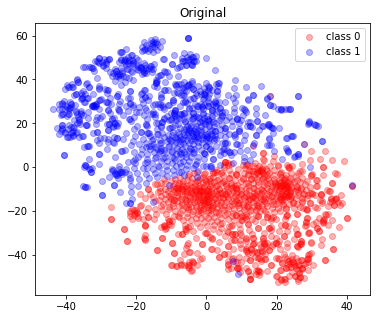

1006
994


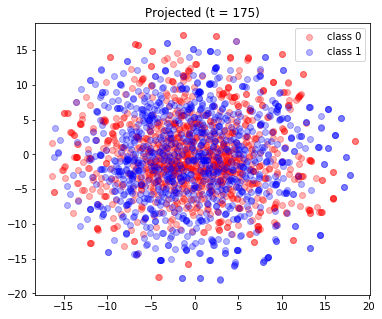

V-measure-before (TSNE space): 0.7777725918172604
V-measure-after (TSNE space): 0.00010831472029976897
V-measure-before (original space): 1.0
V-measure-after (original space): 0.00023837970697422595
Rank before: 300; Rank after: 125


In [9]:
def perform_purity_test(vecs, k, labels_true):
        np.random.seed(0)
        clustering = sklearn.cluster.KMeans(n_clusters = k)
        clustering.fit(vecs)
        labels_pred = clustering.labels_
        score = sklearn.metrics.homogeneity_score(labels_true, labels_pred)
        return score

def compute_v_measure(vecs, labels_true, k=2):
    
        np.random.seed(0)
        clustering = sklearn.cluster.KMeans(n_clusters = k)
        clustering.fit(vecs)
        labels_pred = clustering.labels_
        return sklearn.metrics.v_measure_score(labels_true, labels_pred)
    
#def to_integer(arr, eps = 0.03):
#    return np.array([1 if x > eps else (-1 if x < -eps else 0) for x in arr])
    
#Y_dev = to_integer(Y_dev) #Y_dev > 0
#Y_train = to_integer(Y_train)

# remove the neutral class, if exists

X_dev = X_dev[Y_dev != 0]
X_train = X_train[Y_train != 0]
Y_dev = Y_dev[Y_dev != 0]
Y_train = Y_train[Y_train != 0]

M =  2000

tsne_before = tsne_by_gender(all_significantly_biased_vecs[:M], all_significantly_biased_labels[:M], title = "Original")
X_dev_cleaned = (P.dot(X_dev.T)).T 
X_test_cleaned = (P.dot(X_test.T)).T 
X_trained_cleaned = (P.dot(X_train.T)).T 
all_significantly_biased_cleaned = P.dot(all_significantly_biased_vecs.T).T

tsne_after = tsne_by_gender(all_significantly_biased_cleaned[:M], all_significantly_biased_labels[:M], title = "Projected (t = {})".format(n))

#tsne_projection = tsne_by_gender(all_biased_cleaned, all_significantly_biased_labels,title = "after (all)", words = all_significantly_biased_words)

print("V-measure-before (TSNE space): {}".format(compute_v_measure(tsne_before, all_significantly_biased_labels[:M])))
print("V-measure-after (TSNE space): {}".format(compute_v_measure(tsne_after, all_significantly_biased_labels[:M])))

print("V-measure-before (original space): {}".format(compute_v_measure(all_significantly_biased_vecs[:M], all_significantly_biased_labels[:M]), k = 2))
print("V-measure-after (original space): {}".format(compute_v_measure(all_significantly_biased_cleaned[:M], all_significantly_biased_labels[:M]), k = 2))

rank_before = np.linalg.matrix_rank(X_train)
rank_after = np.linalg.matrix_rank(X_trained_cleaned)
print("Rank before: {}; Rank after: {}".format(rank_before, rank_after))

#### Train a nonlinear classifier for gender prediction.

In [10]:
"""
nonlinear_clf = SVC(kernel = "rbf")
print("Before, rbf-svm:")
nonlinear_clf.fit(X_train, Y_train)
print(nonlinear_clf.score(X_dev, Y_dev))

""" 

print("After, linear:")
linear_clf = LinearSVC()
linear_clf.fit(X_trained_cleaned, Y_train)
print(linear_clf.score(X_dev_cleaned, Y_dev))

#print("After, rbf-svm:")
#nonlinear_clf = SVC(kernel = "rbf")
#nonlinear_clf.fit(X_trained_cleaned, Y_train)
#print(nonlinear_clf.score(X_dev_cleaned, Y_dev))

print("After, mlp:")
nonlinear_clf = MLPClassifier(hidden_layer_sizes = 256, activation = "relu")

nonlinear_clf.fit(X_trained_cleaned, Y_train)
print(nonlinear_clf.score(X_dev_cleaned, Y_dev))


After, linear:
0.5027777777777778
After, mlp:
0.7518518518518519


#### project on the gender direction

In [11]:
masc_vecs_cleaned = P.dot(masc_vecs.T).T
fem_vecs_cleaned = P.dot(fem_vecs.T).T

print("masc-bias-before: {}".format(masc_vecs.dot(gender_unit_vec).mean()))
print("masc-bias-after: {}".format(masc_vecs_cleaned.dot(gender_unit_vec.dot(P)).mean()))
print("fem-bias-before: {}".format(fem_vecs.dot(gender_unit_vec).mean()))
print("fem-bias-after: {}".format(fem_vecs_cleaned.dot(gender_unit_vec.dot(P)).mean()))      

masc-bias-before: 1.194366693496704
masc-bias-after: 0.0031349546153181447
fem-bias-before: -1.2111321687698364
fem-bias-after: 0.0018753602460013792


#### calculate the similarity matrix before and after

In [12]:

def get_distance_matrix(vecs: np.ndarray):

  distances = sklearn.metrics.pairwise_distances(vecs, vecs, metric="cosine")
  return distances

def plot_distance(distance_before, distance_after):

    idx = distance_before < 0.75 # we are only interested in the relatively close words

    distance_before = distance_before.copy()[idx]
    distance_after = distance_after.copy()[idx]
    
    chosen = np.random.rand(len(distance_before)) < 0.01
    before = distance_before[chosen]
    after = distance_after[chosen]
    plt.plot(before, after, linestyle="None", marker = "*", alpha = 0.1)
    plt.xlabel("distnace before")
    plt.ylabel("distance after")

    plt.show()
    print("Correlation: {}".format(pearsonr(before, after)[0]))
    
def plot_similarity_change_vs_original_bias(bias_before, distance_before, distance_after):

    K = 50
    most_similar_idx_before = distance_before.argsort(axis = 0)[:K].T
    most_similar_idx_after = distance_after.argsort(axis = 0)[:K].T
    data = []
    
    for i, (bias, dis_before, dis_after) in enumerate(tqdm.tqdm(zip(bias_before, distance_before, distance_after), ascii = True, total = len(bias_before))):
        
        idx_before = set(most_similar_idx_before[i].tolist())
        idx_after = set(most_similar_idx_after[i].tolist())
        intersection = (most_similar_idx_before[i] == most_similar_idx_after[i]).sum() 
        intersection = idx_before.intersection(idx_after)
        data.append((abs(bias), 1 - len(intersection)/K))
        #data.append((abs(bias), 1 - intersection/K))
        
    plt.xlabel("change in similarity (% of of top-{}-similar that changed)".format(K))
    plt.ylabel("bias before")
    biases, sims = zip(*data)    
    plt.plot(sims, biases, linestyle="None", marker = "*", alpha = 0.1)

    plt.show()
    print("Correlation: {}".format(pearsonr(biases, sims)[0]))

In [13]:
vecs_cleaned = (P.dot(vecs.T)).T
save_in_word2vec_format(vecs_cleaned, words, "../data/embeddings/vecs.150k.cleaned.txt")
model_cleaned, _, _ = load_word_vectors(fname = "../data/embeddings/vecs.150k.cleaned.txt")

150000it [00:51, 2895.18it/s]


#### calcualte the similarity of female-stereotyped words to 'girlish', before and after

In [14]:

w = "girlish"
k = 5000

random_fem_words = np.random.choice(fem_words, size = k)
sim_to_girlish_before = [model.similarity(w,w2) for w2 in random_fem_words]
sim_to_girlish_after = [model_cleaned.similarity(w,w2) for w2 in random_fem_words]

print("Similarity of female-stereotyped words to 'girlish' before: {}; similarity after: {}".format(np.mean(sim_to_girlish_before), np.mean(sim_to_girlish_after)))


w = "girlish"

random_masc_words = np.random.choice(masc_words, size = k)
sim_to_girlish_before = [model.similarity(w,w2) for w2 in random_masc_words]
sim_to_girlish_after = [model_cleaned.similarity(w,w2) for w2 in random_masc_words]

print("Similarity of male-stereotyped words to 'girlish' before: {}; similarity after: {}".format(np.mean(sim_to_girlish_before), np.mean(sim_to_girlish_after)))


Similarity of female-stereotyped words to 'girlish' before: 0.10680163651704788; similarity after: 0.019682032987475395
Similarity of male-stereotyped words to 'girlish' before: 0.011595159769058228; similarity after: 0.012253240682184696


### Calcualte bias-by-clustering

In [15]:
def numerical_bias_by_clustering(model_before, model_after, masc_words, fem_words, k):
    
    scores_before, scores_after = [], []
    all_biased = masc_words.union(fem_words)
    
    for w in all_biased:
        
        most_similar_before = model_before.most_similar(w, topn = k)
        most_similar_before, _ = zip(*most_similar_before)

        most_similar_after = model_after.most_similar(w, topn = k)
        most_similar_after, _ = zip(*most_similar_after)
        
        neighbors_biased_before = len([w for w in most_similar_before if w in all_biased])
        neighbors_biased_after = len([w for w in most_similar_after if w in all_biased])
        scores_before.append(neighbors_biased_before)
        scores_after.append(neighbors_biased_after)
    print("avg. number of biased neighbors before: {}; after: {}".format(np.mean(scores_before), np.mean(scores_after)))
    
    
    
    

In [16]:
#numerical_bias_by_clustering(model, model_cleaned, set(masc_words), set(fem_words), k = 1000)

#### print the most similar words to random words before and after (to make sure we didn't damage the space too much)

In [17]:
from collections import defaultdict
import pickle

words_chosen = np.random.choice(words[:15000] , size = 100)
topn = 4
words_before_and_after = defaultdict(dict)

for w in words_chosen:
    words_and_sims_before = model.most_similar(w, topn = topn)
    words__and_sims_after = model_cleaned.most_similar(w, topn = topn)
    words_before, _ = zip(*words_and_sims_before)
    words_after, _ = zip(*words__and_sims_after)
    words_before_and_after[w]["before"] = words_before
    words_before_and_after[w]["after"] = words_after
    print("w: {}\n most-similar-before: {}\n most-similar-after: {}".format(w,words_before, words_after))
    print("----------------------------------")

print("====================================================================\n\n")
print("gendered words:")
words_chosen = ["miss", "mrs", "mr", "john", "rachel", "wife", "mom", "family", "father", "lady", "he", "she"]
for w in words_chosen:
    
    words_and_sims_before = model.most_similar(w, topn = topn)
    words__and_sims_after = model_cleaned.most_similar(w, topn = topn)
    words_before, _ = zip(*words_and_sims_before)
    words_after, _ = zip(*words__and_sims_after)
    print("w: {}\n most-similar-before: {}\n most-similar-after: {}".format(w,words_before, words_after))
    print("----------------------------------")    
    
with open("words_before_and_after.pickle", "wb") as f:
    pickle.dump(words_before_and_after, f)

w: tracks
 most-similar-before: ('track', 'songs', 'album', 'albums')
 most-similar-after: ('track', 'remixes', 'unreleased', 'songs')
----------------------------------
w: antique
 most-similar-before: ('vintage', 'antiques', 'deco', 'victorian')
 most-similar-after: ('vintage', 'deco', 'antiqued', 'pewter')
----------------------------------
w: tapping
 most-similar-before: ('tap', 'tapped', 'turning', 'taps')
 most-similar-after: ('tap', 'tapped', 'swiping', 'finger')
----------------------------------
w: battalion
 most-similar-before: ('regiment', 'infantry', 'brigade', 'battalions')
 most-similar-after: ('regiment', 'brigade', 'battalions', 'infantry')
----------------------------------
w: park
 most-similar-before: ('parks', 'gardens', 'hill', 'grove')
 most-similar-after: ('parks', 'parkway', 'grove', 'woodlawn')
----------------------------------
w: happened
 most-similar-before: ('happen', 'happens', 'happening', 'knew')
 most-similar-after: ('happend', 'transpired', 'happen'

w: governance
 most-similar-before: ('accountability', 'institutional', 'sustainability', 'initiatives')
 most-similar-after: ('management', 'organizational', 'accountability', 'oversight')
----------------------------------
w: fairly
 most-similar-before: ('quite', 'relatively', 'surprisingly', 'pretty')
 most-similar-after: ('relatively', 'quite', 'pretty', 'very')
----------------------------------
w: syntax
 most-similar-before: ('parsing', 'semantics', 'formatting', 'parser')
 most-similar-after: ('parsing', 'semantics', 'formatting', 'xpath')
----------------------------------
w: separate
 most-similar-before: ('seperate', 'two', 'multiple', 'separated')
 most-similar-after: ('seperate', 'separated', 'two', 'separating')
----------------------------------
w: montgomery
 most-similar-before: ('county', 'franklin', 'jefferson', 'alabama')
 most-similar-after: ('fayette', 'dekalb', 'decatur', 'germantown')
----------------------------------
w: whip
 most-similar-before: ('whipped', 

w: mr
 most-similar-before: ('mrs', 'sir', 'minister', 'chief')
 most-similar-after: ('mrs', 'cllr', 'messrs', 'praveen')
----------------------------------
w: john
 most-similar-before: ('james', 'william', 'paul', 'george')
 most-similar-after: ('quiggin', 'gorka', 'betjeman', 'scatman')
----------------------------------
w: rachel
 most-similar-before: ('sarah', 'rebecca', 'emily', 'katie')
 most-similar-after: ('maddow', 'aziani', 'ashwell', 'bilson')
----------------------------------
w: wife
 most-similar-before: ('husband', 'daughter', 'mother', 'married')
 most-similar-after: ('husband', 'girlfriend', 'wives', 'wfe')
----------------------------------
w: mom
 most-similar-before: ('dad', 'mother', 'mommy', 'mum')
 most-similar-after: ('dad', 'mum', 'grandma', 'mother')
----------------------------------
w: family
 most-similar-before: ('families', 'parents', 'friends', 'children')
 most-similar-after: ('families', 'familys', 'familiy', 'uproot')
--------------------------------

### bias by profession experiment

In [18]:
def get_bias_by_neighbors(model, model_cleaned, gendered_words, v, gender_direction): 
    
    neighbors = model_cleaned.similar_by_vector(v, topn=100) 
    neighbors_words = [n for n, _ in neighbors]
    
    #bias = len([n for n in neighbors_words if n in gendered_words])
    bias = len([n for n in neighbors_words if model.cosine_similarities(model[n], [gender_direction])[0] > 0])
    return bias

def bias_by_profession(model, model_cleaned, gender_direction, P, masc_words):
    
    with codecs.open("../data/lists/professions.json") as f:
        professions_and_scores = json.load(f)

    professions = [p[0] for p in professions_and_scores]
    #print(professions)
    professions = list(filter(lambda p: p in model.wv, professions))
    vecs = np.array([model[p] for p in professions])
    vecs_cleaned = vecs.dot(P)
    bias_vals = np.array([model.cosine_similarities(gender_direction,vecs)])[0]
    #bias_vals_after = np.array([model.cosine_similarities(gender_direction,vecs_cleaned)])[0]
    bias_by_neighbors_after = np.array([get_bias_by_neighbors(model, model_cleaned, masc_words, v, gender_direction) for v in vecs_cleaned])
    bias_by_neighbors_before = np.array([get_bias_by_neighbors(model, model, masc_words, v, gender_direction) for v in vecs])

    #plt.ylim([np.min(bias_vals), np.max(bias_vals)])
    plt.plot(bias_vals, bias_by_neighbors_after, marker = "o", linestyle = "none", color = "red", label = "after", alpha = 0.25)
    plt.plot(bias_vals, bias_by_neighbors_before, marker = "o", linestyle = "none", color = "blue", label = "before", alpha = 0.25)
    
    word_idx_high = np.argsort(bias_vals)[:4] 
    word_idx_low = np.argsort(bias_vals)[-4:]
    word_idx_middle_low = np.argsort(bias_vals)[-55:-51]
    word_idx_middle_high = np.argsort(bias_vals)[51:55]
    words_biased_fem = [professions[i] for i in word_idx_high]
    words_biased_masc = [professions[i] for i in word_idx_low]
    mid_low = [professions[i] for i in word_idx_middle_low]
    mid_high = [professions[i] for i in word_idx_middle_high]
    words = words_biased_masc + words_biased_fem + mid_low + mid_high
    
    for w in words:
        i = professions.index(w)
        x1,y1 = bias_vals[i],bias_by_neighbors_after[i]
        plt.annotate(w , (x1,y1), size = 8, color = "red")
        x2,y2 = bias_vals[i],bias_by_neighbors_before[i]
        plt.annotate(w, (x2,y2), size = 8, color = "blue")
        #plt.arrow(x2,y2,x1-x2,y1-y2, width = 0.0005)
        
    plt.legend()
    plt.xlabel("bias-by-PROJECTION of the professions before")
    plt.ylabel("bias-by-NEIGHBORS")
    plt.title("projection bias before vs. neighbors bias before/after \n(# neighbors closer to 'she' then 'he')")
    plt.show()
    
    print("Correlation before: {}, p-value: {}".format(*pearsonr(bias_vals, bias_by_neighbors_before)))
    print("Correlation after: {}, p-value: {}".format(*pearsonr(bias_vals, bias_by_neighbors_after)))

        

/home/shauli/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:17: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).


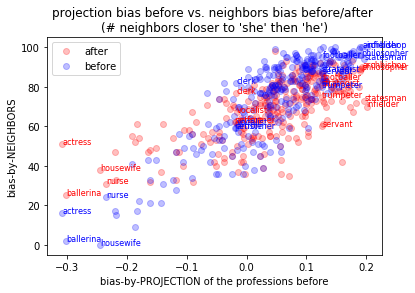

Correlation before: 0.8524125255827101, p-value: 2.268076571430645e-83
Correlation after: 0.6844035985787535, p-value: 1.5141742724175354e-41


In [19]:
bias_by_profession(model, model_cleaned, gender_direction, P, None)

In [20]:
"""
for i, (w,v,l) in enumerate(zip(all_significantly_biased_words,all_biased_cleaned,
                               all_significantly_biased_labels)):
    
    neighbors = model_cleaned.similar_by_vector(v, topn = 6, restrict_vocab=None)[1:]
    print(w, neighbors)
    print("===========================================")
 """

'\nfor i, (w,v,l) in enumerate(zip(all_significantly_biased_words,all_biased_cleaned,\n                               all_significantly_biased_labels)):\n    \n    neighbors = model_cleaned.similar_by_vector(v, topn = 6, restrict_vocab=None)[1:]\n    print(w, neighbors)\n    print("===========================================")\n '

### word association tests

In [21]:
# Auxiliary functions for experiments by Caliskan et al.

import scipy
import scipy.misc as misc
import itertools


def s_word(w, A, B, model, all_s_words):
    
    if w in all_s_words:
        return all_s_words[w]
    
    mean_a = []
    mean_b = []
    
    for a in A:
        mean_a.append(model.similarity(w,a))
    for b in B:
        mean_b.append(model.similarity(w,b))
        
    mean_a = sum(mean_a)/float(len(mean_a))
    mean_b = sum(mean_b)/float(len(mean_b))
    
    all_s_words[w] = mean_a - mean_b

    return all_s_words[w]


def s_group(X, Y, A, B, model, all_s_words):
    
    total = 0
    for x in X:
        x_sim = s_word(x, A, B, model, all_s_words)
        total += x_sim
    for y in Y:
        y_sim =  s_word(y, A, B, model, all_s_words)
        total -= y_sim
    
    #print(x_sim, y_sim)
        
    return total


def p_value_exhust(X, Y, A, B, model):
    
    if len(X) > 10:
        print ('might take too long, use sampled version: p_value')
        return
    
    assert(len(X) == len(Y))
    
    all_s_words = {}
    s_orig = s_group(X, Y, A, B, model, all_s_words)
    #print("s-orig: {}".format(s_orig))
    
    union = set(X+Y)
    subset_size = int(len(union)/2)
    
    larger = 0
    total = 0
    #all_subs = set(itertools.combinations(union, subset_size))
    #print(all_subs)
    for subset in tqdm.tqdm(set(itertools.combinations(union, subset_size))):
        total += 1
        Xi = list(set(subset))
        Yi = list(union - set(subset))
        if s_group(Xi, Yi, A, B, model, all_s_words) > s_orig:
            larger += 1
    #print ('num of samples', total)
    return larger/float(total)


def p_value_sample(X, Y, A, B, model):
    
    random.seed(10)
    np.random.seed(10)
    all_s_words = {}
    
    assert(len(X) == len(Y))
    length = len(X)
    
    s_orig = s_group(X, Y, A, B, model, all_s_words) 
    
    num_of_samples = min(10000, int(scipy.special.comb(length*2,length)*100))
    print ('num of samples', num_of_samples)
    larger = 0
    for i in range(num_of_samples):
        permute = np.random.permutation(X+Y)
        Xi = permute[:length]
        Yi = permute[length:]
        if s_group(Xi, Yi, A, B, model, all_s_words) > s_orig:
            larger += 1
    
    return larger/float(num_of_samples)

In [22]:
# Experiment 1

A = ['john', 'paul', 'mike', 'kevin', 'steve', 'greg', 'jeff', 'bill']
B = ['amy', 'joan', 'lisa', 'sarah', 'diana', 'kate', 'ann', 'donna']

C = ['executive', 'management', 'professional', 'corporation', 'salary', 'office', 'business', 'career']
D = ['home', 'parents', 'children', 'family', 'cousins', 'marriage', 'wedding', 'relatives']

print (p_value_exhust(A, B, C, D, model_cleaned))

# Experiment 2

E = ['math', 'algebra', 'geometry', 'calculus', 'equations', 'computation', 'numbers', 'addition']
F = ['poetry', 'art', 'dance', 'literature', 'novel', 'symphony', 'drama', 'sculpture']

print (p_value_exhust(A, B, E, F, model_cleaned))


# Experiment 3

G = ['science', 'technology', 'physics', 'chemistry', 'einstein', 'nasa', 'experiment', 'astronomy']
H = ['poetry', 'art', 'shakespeare', 'dance', 'literature', 'novel', 'symphony', 'drama']

print (p_value_exhust(A, B, G, H, model_cleaned))

100%|██████████| 12870/12870 [00:00<00:00, 159085.38it/s]

0.6076923076923076
0.1188034188034188
0.22004662004662004


### Compare with debiasing on specific directions

In [23]:
specific_words = [("he", "she"), ("man", "woman"), ("boy", "girl"), ("him", "her"), ("father", "mother")]

In [24]:
vecs_specific_words = np.array([ [model[p[1]] - model[p[0]]] for p in specific_words])
P_by_words = debias.debias_by_specific_directions(vecs_specific_words, 300) # projection matrix generated by zeroing the above directions
X_dev_cleaned = (P_by_words.dot(X_dev.T)).T
X_train_cleaned = (P_by_words.dot(X_train.T)).T

In [25]:
clf = LinearSVC()
clf.fit(X_train_cleaned, Y_train)
print(clf.score(X_dev_cleaned, Y_dev))

0.8555555555555555


/home/shauli/miniconda3/envs/py3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


#### PCA

In [310]:
gender_vecs = [model[p[0]] - model[p[1]] for p in specific_words]
pca = PCA(n_components=1)
pca.fit(gender_vecs)
gender_direction = pca.components_
P_by_words = debias.debias_by_specific_directions(np.array([gender_direction]), 300) # projection matrix generated by zeroing the above directions
X_dev_cleaned = (P_by_words.dot(X_dev.T)).T
X_train_cleaned = (P_by_words.dot(X_train.T)).T

In [33]:
clf = LinearSVC()
clf.fit(X_train_cleaned, Y_train)
print(clf.score(X_dev_cleaned, Y_dev))

0.999


A linear classifier is still able to recover the gender with non-random accuracy.

1006
994


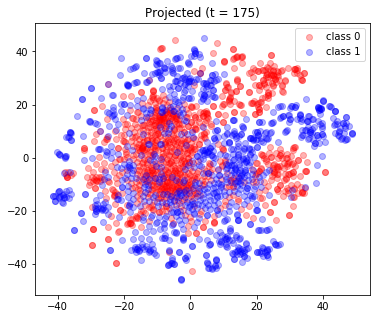

V-measure-before (original space): 1.0
V-measure-after (original space): 0.0002856749169515934


In [26]:
M =  2000

#tsne_before = tsne_by_gender(all_significantly_biased_vecs[:M], all_significantly_biased_labels[:M], title = "Original")
X_dev_cleaned = (P_by_words.dot(X_dev.T)).T #X_dev.dot(P)
X_test_cleaned = (P_by_words.dot(X_test.T)).T #X_test.dot(P)
X_trained_cleaned = (P_by_words.dot(X_train.T)).T #X_train.dot(P)
all_significantly_biased_cleaned = P_by_words.dot(all_significantly_biased_vecs.T).T

tsne_after = tsne_by_gender(all_significantly_biased_cleaned[:M], all_significantly_biased_labels[:M], title = "Projected (t = {})".format(n))
print("V-measure-before (original space): {}".format(compute_v_measure(all_significantly_biased_vecs[:M], all_significantly_biased_labels[:M])))
print("V-measure-after (original space): {}".format(compute_v_measure(all_significantly_biased_cleaned[:M], all_significantly_biased_labels[:M])))